# Продажи австралийского вина

Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие три года.

In [70]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.3 MB/s 
     |████████████████████████████████| 9.9 MB 38.8 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [71]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from itertools import product

import pmdarima as pm

plt.rcParams['figure.figsize'] = (15, 7)
warnings.filterwarnings('ignore')

In [ ]:
# Определим функцию для возвращения исходных данных после процедуры Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [124]:
# Загрузим данные и взгляним на них
wine = pd.read_csv('/datasets/monthly-australian-wine-sales.csv', sep=',', index_col=['month'], parse_dates=['month'])['sales']
wine

month
1980-01-01    15136
1980-02-01    16733
1980-03-01    20016
1980-04-01    17708
1980-05-01    18019
              ...  
1994-04-01    26323
1994-05-01    23779
1994-06-01    27549
1994-07-01    29660
1994-08-01    23356
Name: sales, Length: 176, dtype: int64

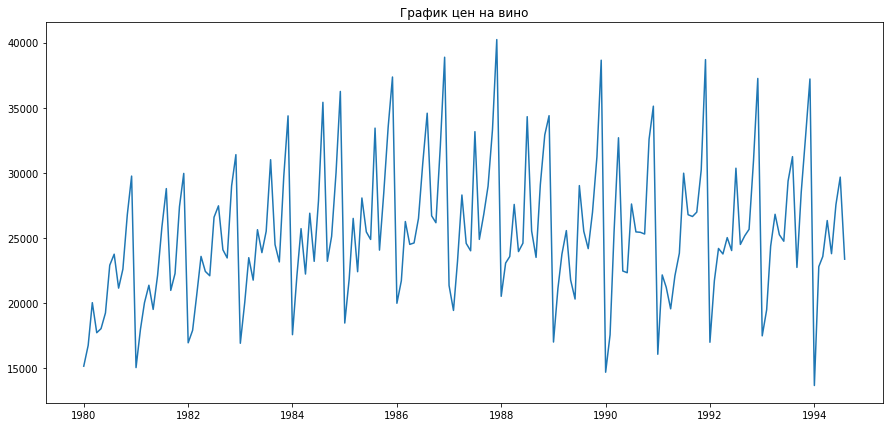

In [32]:
# Визуализируем исходный ряд
plt.plot(wine)
plt.title('График цен на вино')
plt.show()

In [33]:
# Из графика понятно, что ряд нестационарен, проверим это формальным тестом
print("Критерий Шапиро-Уилка: p=%f" % stats.shapiro(wine)[1])

Критерий Шапиро-Уилка: p=0.008173


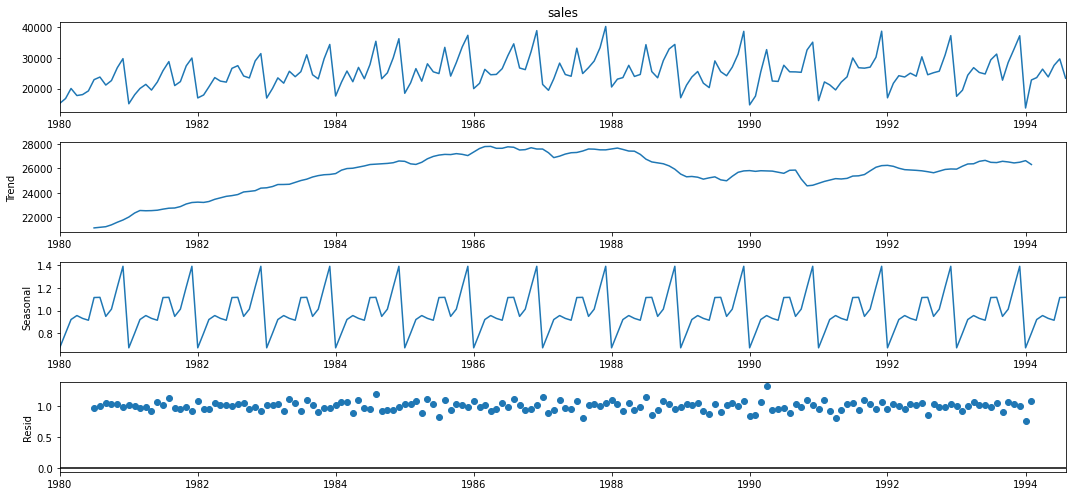

In [125]:
# Сделаем сезонную декомпозицию, используя мультипликативную модель, так как наблюдается изменение вариации, поставим период в 1 год
sm.tsa.seasonal_decompose(wine, model='multiplicative', period=12).plot()
plt.show()

In [37]:
# Сделаем преобразование Бокса-Кокса для стабилизации дисперсии и сглаживания данных
wine_box, lmbda = stats.boxcox(wine)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.236675


In [38]:
# Проверим стационарность для сглаженного ряда
print("Критерий Шапиро: p=%f" % stats.shapiro(wine_box)[1])

Критерий Шапиро: p=0.344414


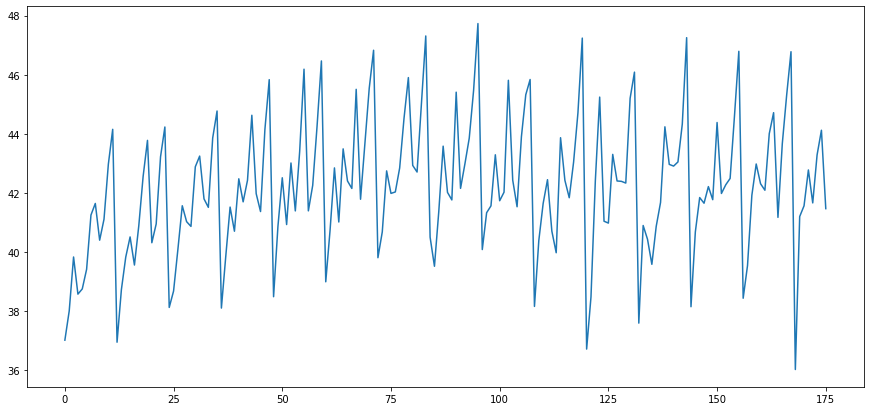

In [39]:
# Визуализируем сглаженный ряд
plt.plot(wine_box)
plt.show()

In [40]:
# Тест указывает на стационарность, но все еще есть тренд и сезонность. Попробуем избавиться от сезонности через дифференциирование
wine_diff_seasonal = pd.Series(wine_box).diff(12).dropna()
print("Критерий Шапиро: p=%f" % stats.shapiro(wine_diff_seasonal)[1])

Критерий Шапиро: p=0.000002


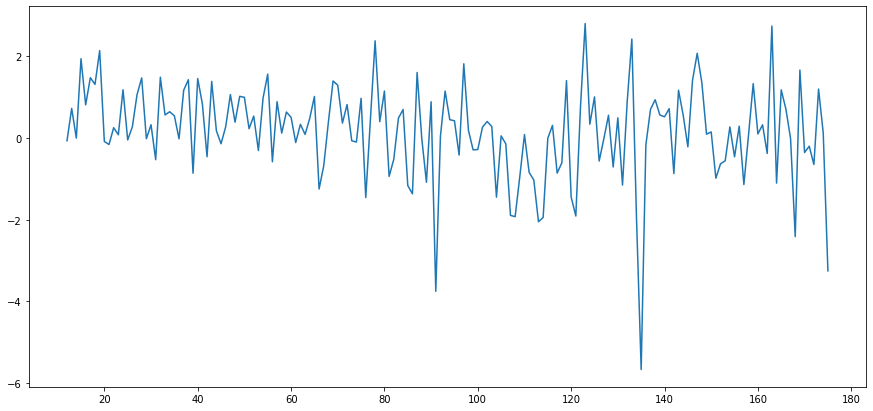

In [42]:
# Взглянем на ряд, дифференциированный по сезонному периоду в 12 месяцев
plt.plot(wine_diff_seasonal)
plt.show()

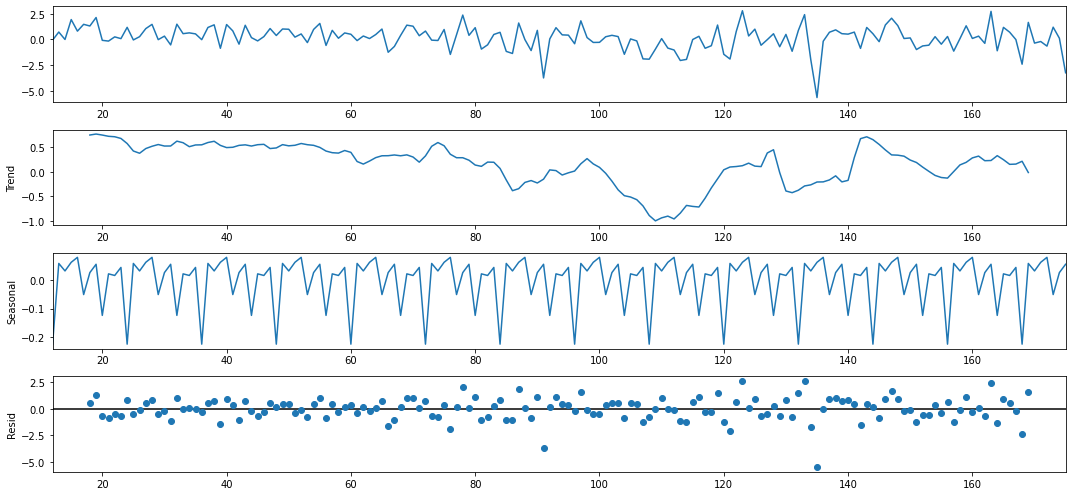

In [48]:
# Удалось избавиться от сезонности, но все еще виден тренд. Проверим это через декомпозицию. Оставим период в 12 месяцев. Здесь можно оставить аддитивную модель 
sm.tsa.seasonal_decompose(wine_diff_seasonal, period=12).plot()
plt.show()

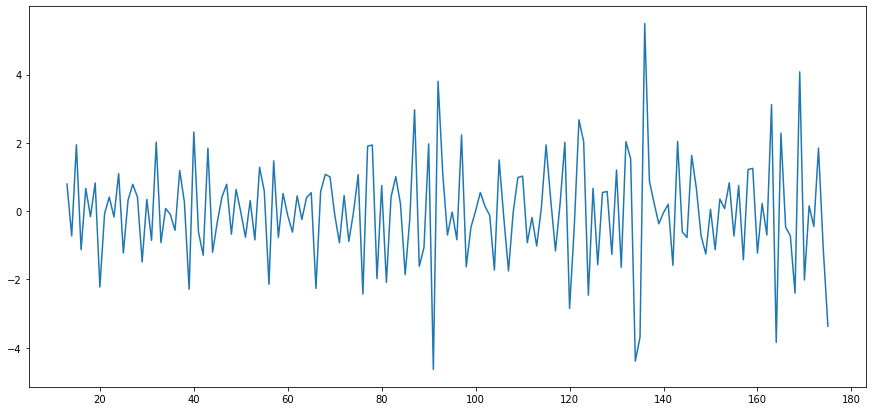

In [50]:
# Продифференциируем на 1 период для избавления от тренда и визуализируем
wine_diff = wine_diff_seasonal.diff(1).dropna()

plt.plot(wine_diff)
plt.show()

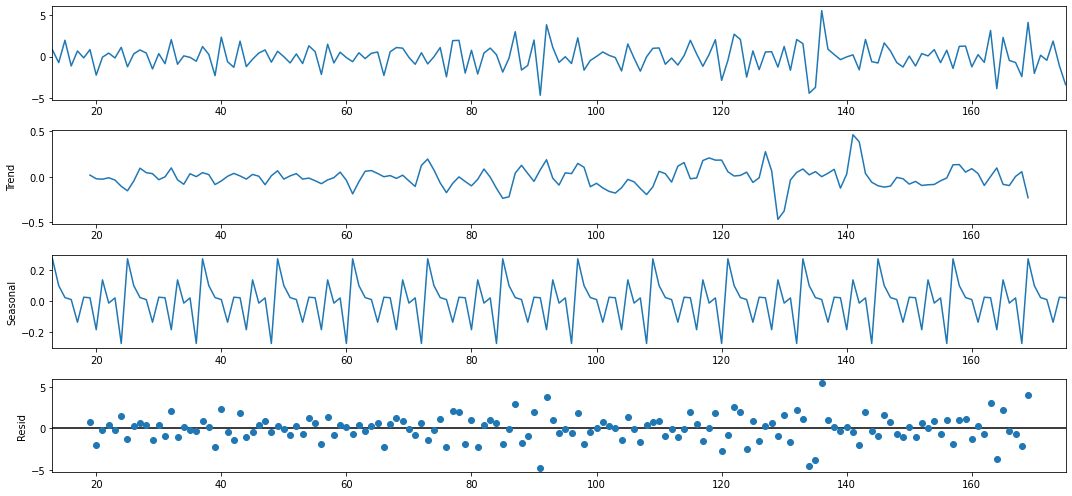

In [51]:
# Выглядит так, что получилось избавиться от тренда. Проверим это через ту же декопозицию
sm.tsa.seasonal_decompose(wine_diff, period=12).plot()
plt.show()

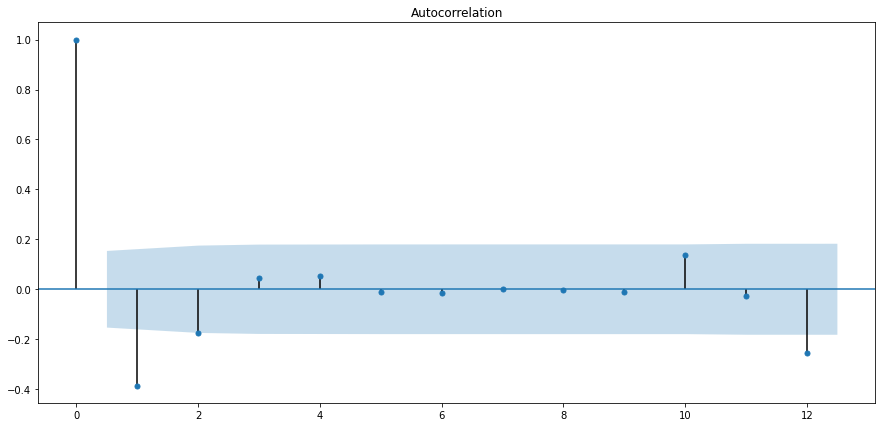

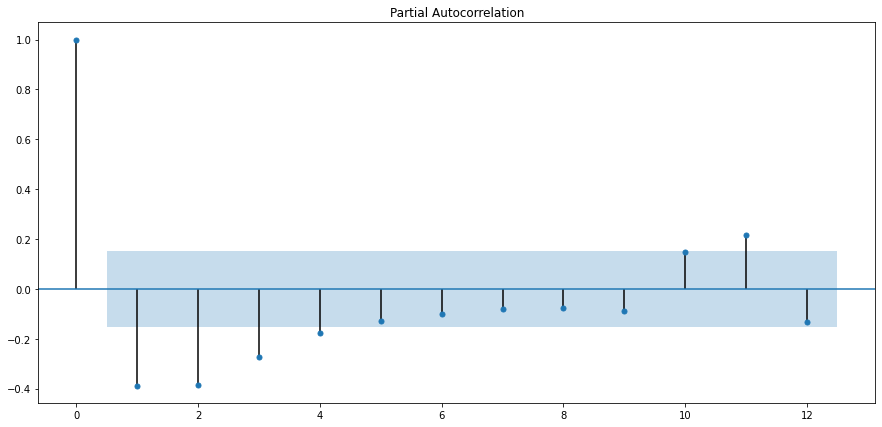

In [60]:
# Теперь поберем гипрепараметры для ARIMA-модели через ACF и PACF
sm.graphics.tsa.plot_acf(wine_diff, lags=12)
plt.show()
sm.graphics.tsa.plot_pacf(wine_diff, lags=12)
plt.show()

* PACF планомерно падает, тогда как первый лаг ACF вне ДИ. Походит на модель ARMA(0,1)

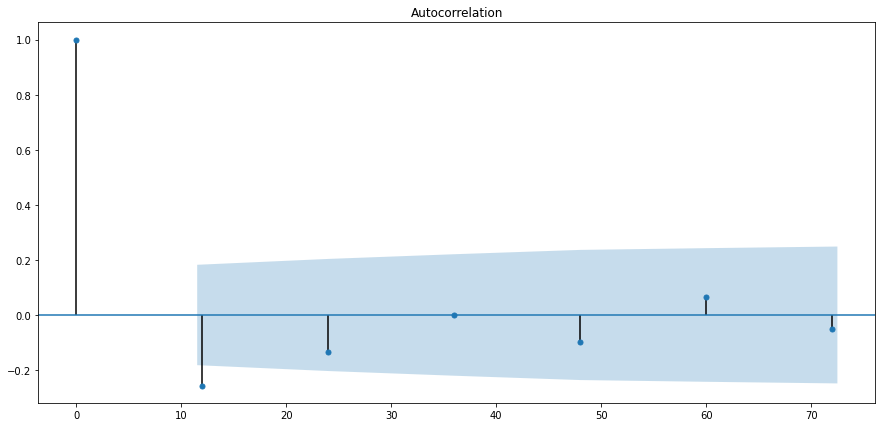

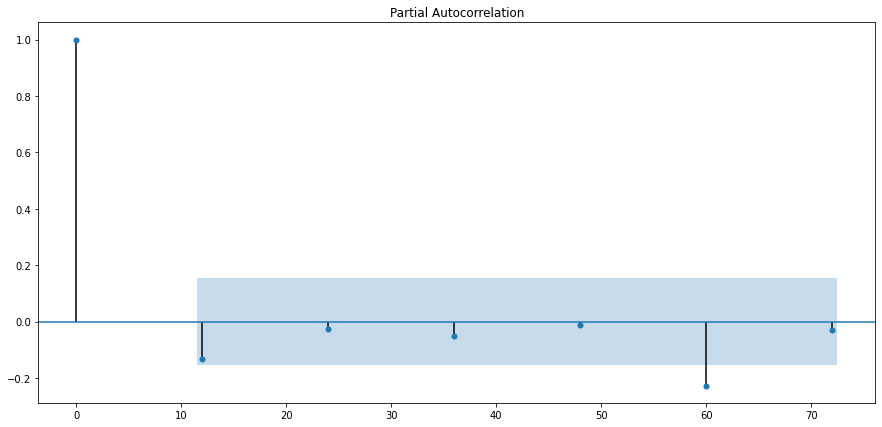

In [62]:
# Теперь попробуем подобрать параметры для сезонной компоненты
sm.graphics.tsa.plot_acf(wine_diff, lags=[0, 12, 24, 36, 48, 60, 72])
plt.show()
sm.graphics.tsa.plot_pacf(wine_diff, lags=[0, 12, 24, 36, 48, 60, 72])
plt.show()

* Отсюда мало что понятно. Пока возьмем P=0 и Q=0, построим такую модель. После этого через библиотеку вычислим лучшую модель с точки зрения информационных критериев и взглянем, насколько точны были предположения из ACF/PACF

In [76]:
# Построим модель со следующими параметрами: p=0, d=1, q=1, P=0, D=1, Q=0, m=12
model=sm.tsa.statespace.SARIMAX(wine_box, order=(0, 1, 1), seasonal_order=(0, 1, 0, 12)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  176
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -254.478
Date:                             Tue, 06 Dec 2022   AIC                            512.956
Time:                                     18:26:24   BIC                            519.143
Sample:                                          0   HQIC                           515.468
                                             - 176                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9510      0.025    -37.662      0.000      -1.000      -0.901
sigma2         1.3101      0.086     15.161      0.000       1.141       1.480
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                98.78
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
# Найдем лучшую модель через автоматизированную библиотеку
best_model = pm.auto_arima(wine_box, start_p=1, start_q=1, max_p=3, max_q=3, d=1, D=1, m=12)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -233.157
Date:                            Tue, 06 Dec 2022   AIC                            476.314
Time:                                    18:27:24   BIC                            491.783
Sample:                                         0   HQIC                           482.594
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0040      0.002     -2.027      0.043      -0.008      -0.000
ma.L1         -0.9157      0.037    -24.701      0.000      -0.988      -0.843
ar.S.L12       0.2136      0.108      1.980      0.048       0.002       0.425
ma.S.L12      -0.8115      0.095     -8.558      0.000      -0.997      -0.626
sigma2         0.9553      0.087     10.933      0.000       0.784       1.127
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                32.48
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               2.69   Skew:                            -0.52
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

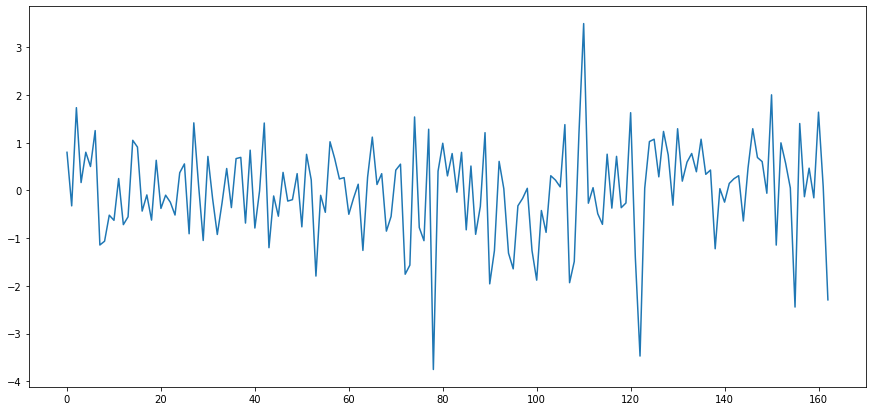

In [79]:
# Посмотрим на остатки лучшей модели
plt.plot(best_model.resid()[13:])
plt.show()

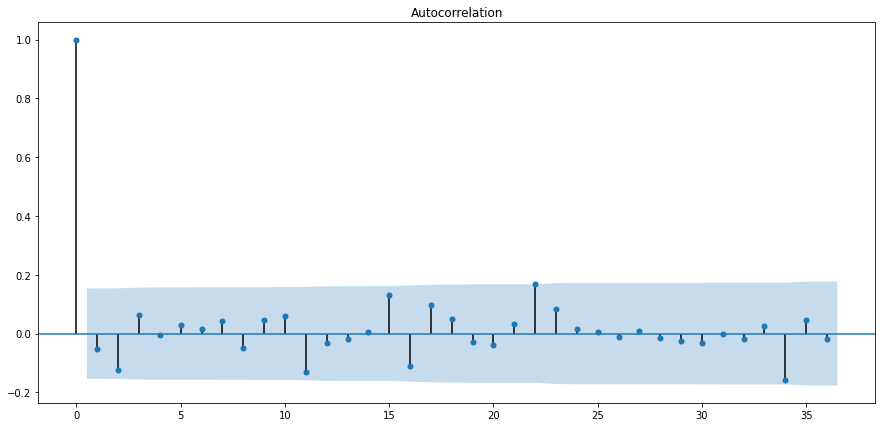

Ttest_1sampResult(statistic=-0.14628633020524118, pvalue=0.8838772324509092)
4.350497063271383e-18


In [96]:
# Проверим отсутствие автокорреляции, несмещенность и стационарность ряда остатков лушчей модели
sm.graphics.tsa.plot_acf(best_model.resid()[13:], lags=36)
plt.show()

print(stats.ttest_1samp(best_model.resid()[13:], 0))
print(sm.tsa.stattools.adfuller(best_model.resid()[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

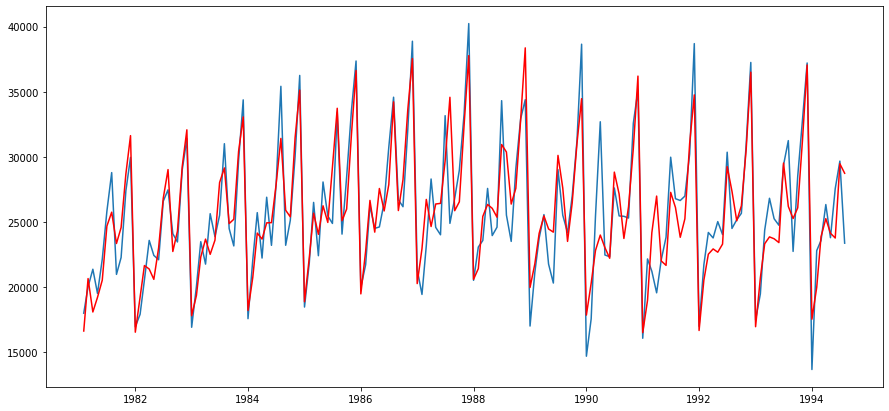

In [104]:
# Проверим, насколько близко модель оценивает реальные данные
fitted_data = invboxcox(best_model.fittedvalues(), lmbda)

plt.plot(wine.index[13:], wine[13:])
plt.plot(wine.index[13:], fitted_data[13:], color='r')
plt.show()

In [118]:
# Проверим работу прогнозирования
best_model.predict(n_periods=36)

array([41.59722101, 42.92072603, 44.73655509, 46.43507293, 37.16634704,
       40.26759482, 41.34357556, 42.11203179, 41.366948  , 41.93929627,
       43.69487188, 42.23119662, 41.45362485, 42.52233357, 44.37149401,
       46.11358395, 37.1618804 , 39.81410084, 41.03830099, 41.70739752,
       41.03780909, 41.38109149, 43.3288856 , 42.11638615, 41.13860234,
       42.14891984, 44.00124676, 45.74869108, 36.86076382, 39.41309611,
       40.66500826, 41.30892218, 40.65150845, 40.94189687, 42.92680328,
       41.76401218])

In [114]:
# Проверим создание будущего ряда с датами для прогноза
pd.date_range(start='1994-09-01', periods=36, freq=pd.offsets.MonthBegin(1))

DatetimeIndex(['1994-09-01', '1994-10-01', '1994-11-01', '1994-12-01',
               '1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01', '1995-11-01', '1995-12-01',
               '1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01'],
              dtype='datetime64[ns]', freq='MS')

In [122]:
# Сцепим даты и прогноз в один ряд
forecast = pd.Series(invboxcox(best_model.predict(n_periods=36), lmbda), index = pd.date_range(start='1994-09-01', periods=36, freq=pd.offsets.MonthBegin(1)))
forecast

1994-09-01    23662.187677
1994-10-01    26687.277344
1994-11-01    31307.732230
1994-12-01    36160.055942
1995-01-01    15397.253830
1995-02-01    20894.001432
1995-03-01    23113.692459
1995-04-01    24805.945132
1995-05-01    23163.824127
1995-06-01    24417.577573
1995-07-01    28588.430552
1995-08-01    25076.603548
1995-09-01    23350.462770
1995-10-01    25747.344245
1995-11-01    30333.229956
1995-12-01    35200.371470
1996-01-01    15390.234680
1996-02-01    20008.870454
1996-03-01    22466.481569
1996-04-01    23903.509442
1996-05-01    22465.449975
1996-06-01    23194.200845
1996-07-01    27677.189686
1996-08-01    24815.795732
1996-09-01    22677.583560
1996-10-01    24889.489257
1996-11-01    29368.707400
1996-12-01    34134.811473
1997-01-01    14922.645674
1997-02-01    19250.296594
1997-03-01    21693.970727
1997-04-01    23039.516710
1997-05-01    21666.418831
1997-06-01    22264.998914
1997-07-01    26701.815337
1997-08-01    24028.241950
Freq: MS, dtype: float64

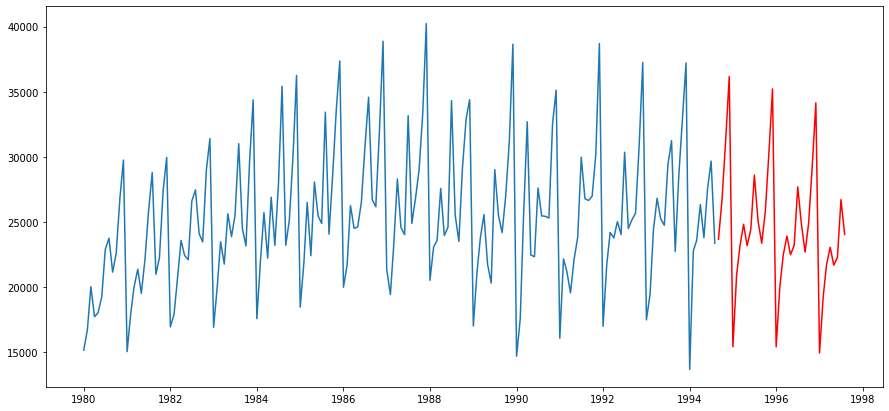

In [123]:
# Визуализируем фактические данные и прогноз на 3 года
plt.plot(wine)
plt.plot(forecast, color='r')
plt.show()